In [1]:
import os

# Change the current directory to root directory
new_directory = "../"
os.chdir(new_directory)

# Verify the current directory has changed
updated_directory = os.getcwd()
print("Updated Directory:", updated_directory)

Updated Directory: /media/toma/2TB_30May2023/OBJECT_DETECTION_L/object_detection


### Pre-loaded data creation

In [2]:
from datasets import load_dataset

IMAGENET_DIR = "data/imagenet_1k"
imagenet_dataset = load_dataset("utils/imagenet_1k_dataset_script.py", data_dir=IMAGENET_DIR, splits = ["validation"], cache_dir=".cache")


/media/toma/2TB_30May2023/OBJECT_DETECTION_L/object_detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset imagenet_1k_dataset_script (/media/toma/2TB_30May2023/OBJECT_DETECTION_L/object_detection/.cache/imagenet_1k_dataset_script/default-data_dir=data%2Fimagenet_1k/1.0.0/a5e211947a658bf65fe00642259511dbb3d3443fdb76fe5d95a69e50de1452a9)
100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


In [3]:
imagenet_dataset["validation"][3456]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=373x560>,
 'label': 72}

In [6]:
if not os.path.exists("preloaded_data_imagenet"):
    os.makedirs("preloaded_data_imagenet") 

In [7]:
imagenet_dataset["validation"].to_parquet("preloaded_data_imagenet/validation.parquet")

Creating parquet from Arrow format: 100%|██████████| 50/50 [00:00<00:00, 3251.65ba/s]


3756250

#### Load pre-loaded data

In [8]:
imagenet_dataset = load_dataset("parquet", data_files={"validation": "preloaded_data_imagenet/validation.parquet"})

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1050.94it/s]


Dataset parquet downloaded and prepared to /home/toma/.cache/huggingface/datasets/parquet/default-cf7323d42978dad3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 275.45it/s]


In [9]:
imagenet_dataset["validation"][3456]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=373x560>,
 'label': 72}

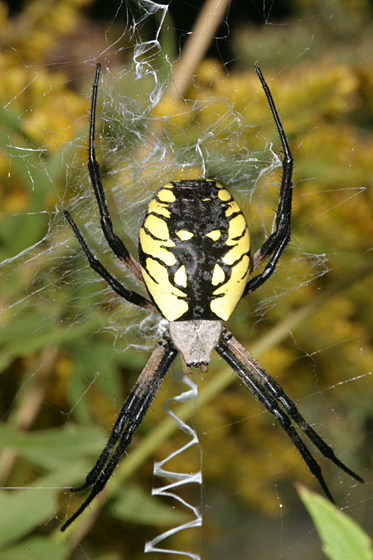

In [11]:
imagenet_dataset["validation"][3456]["image"]

In [10]:
from transformers import AutoImageProcessor

checkpoint = "microsoft/focalnet-tiny"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [12]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])


def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

imagenet_dataset_transformed = imagenet_dataset.with_transform(transforms)

In [14]:
imagenet_dataset_transformed["validation"][3456]["pixel_values"]

tensor([[[ 0.2624,  0.2453,  0.2282,  ..., -0.1657, -0.1486, -0.1486],
         [ 0.1939,  0.1597,  0.1254,  ..., -0.0801, -0.0801, -0.1657],
         [ 0.1083,  0.1083,  0.0741,  ..., -0.0629, -0.0801, -0.1828],
         ...,
         [ 0.0398,  0.0056, -0.0629,  ...,  0.3823,  0.4508,  0.5707],
         [-0.0458, -0.0801, -0.1143,  ...,  0.5193,  0.5878,  0.7077],
         [-0.1314, -0.1314, -0.1657,  ...,  0.6563,  0.7077,  0.7933]],

        [[-0.1450, -0.1625, -0.1975,  ..., -0.1625, -0.1975, -0.2675],
         [-0.2325, -0.2500, -0.2500,  ..., -0.1450, -0.1800, -0.2150],
         [-0.3200, -0.2850, -0.2850,  ..., -0.0924, -0.1450, -0.1975],
         ...,
         [ 0.2402,  0.2402,  0.2227,  ...,  0.1877,  0.3102,  0.3978],
         [ 0.2402,  0.2052,  0.1877,  ...,  0.3627,  0.4678,  0.5203],
         [ 0.2052,  0.2227,  0.1877,  ...,  0.4853,  0.5728,  0.6604]],

        [[-0.8633, -0.8807, -0.9156,  ..., -0.6715, -0.6890, -0.7064],
         [-0.8633, -0.9504, -0.9853,  ..., -0

In [16]:
## DATA COLLATOR

from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

## EVALUATION

import evaluate

accuracy = evaluate.load("accuracy")


import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [30]:
## BUILD MODEL

from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, AutoConfig
import json

config = AutoConfig.from_pretrained('./configs/backbones/focalnet/config.json')

# config_dict = config.__dict__
# print(config_dict)

# read id2label and label2id
with open("configs/datasets/imagenet-1k-id2label.json", 'r') as json_file:
    # Load the JSON data
    id2label = json.load(json_file)


with open("configs/datasets/imagenet-1k-label2id.json", 'r') as json_file:
    # Load the JSON data
    label2id = json.load(json_file)

# config["id2label"] = id2label
# config["label2id"] = label2id
# config["num_labels"] = len(label2id.keys())

config.id2label = id2label
config.label2id = label2id
config.num_labels = len(label2id.keys())


# config = AutoConfig(**config_dict)

model = AutoModelForImageClassification.from_config(config)

In [44]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [47]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=2,
    save_steps = 3,
    max_steps = 6,
    warmup_ratio=0.1,
    no_cuda=True,
    logging_steps=2,
    # load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=imagenet_dataset_transformed["validation"],
    eval_dataset=imagenet_dataset_transformed["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

NameError: name 'PartialState' is not defined

In [ ]:
#### Inference


ds = load_dataset("food101", split="validation[:10]")
image = ds["image"][0]


from transformers import pipeline

classifier = pipeline("image-classification", model="my_awesome_food_model") # must pre-loaded id2label, label2id
classifier(image)